Morgan Turville-Heitz
CS 760
11/5/2023

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
def xbar(D):
    mean_vector = D.mean(axis=1)
    return mean_vector

In [3]:
def stddv(D):
    sigma = D.std(axis = 1)
    return sigma

In [4]:
def svdX(D):
    U, S, VT = np.linalg.svd(D, full_matrices=True)
    return U, S, VT

In [5]:
def buggy_PCA(X, d):
    U, S, VT = svdX(X) 
    A = VT[:d, :].T
    Z = np.matmul(X, A)
    Xr = np.matmul(Z, A.T)
    return Z,  A, Xr, U, S, VT


In [6]:
def demeaned_PCA(X_, d):
    means = xbar(X_)
    X = X_.subtract(means, axis=0)
    U, S, VT = svdX(X) 
    A = VT[:d, :].T
    Z = np.matmul(X, A)
    Xr_ = np.matmul(Z, A.T)
    Xr = Xr_.add(means, axis = 0)
    return Z,  A, Xr, U, S, VT



In [7]:
def normalized_PCA(X_, d):
    means = xbar(X_)
    Xd = X_.subtract(means, axis=0)
    sigma = stddv(Xd)
    X = Xd.divide(sigma, axis = 0) 
    U, S, VT = svdX(X) 
    A = VT[:d, :].T    
    Z = np.matmul(X, A)
    Xr__ = np.matmul(Z, A.T)
    Xr_ = Xr__.multiply(sigma, axis = 0)
    Xr = Xr_.add(means, axis = 0)
    return Z,  A, Xr, U, S, VT

In [ ]:
def DRO(X_, d):
    X_ = X_.T
    eps = 1e-7
    Xbar = X_.mean(axis=0)
    Xc = X_ - Xbar
    U, S, VT = np.linalg.svd(Xc, full_matrices=True)
    Ud = U[:, :d]
    Sd = np.diag(S[:d])
    VTd = VT[:d, :]
    A = VTd.T
    Z_ = np.dot(Ud, Sd)
    Zbar = Z_.mean(axis=0, keepdims=True)
    Z_c = Z_ - Zbar
    Z = Z_c / np.sqrt(S[:d]**2 / (X_.shape[0] - 1) + np.finfo(float).eps)
    covariance_matrix = np.dot(Z.T, Z) / (X_.shape[0] - 1)
    # Print out the covariance matrix to check for identity
    # Leaving this in since it's essential to the problem description
    print(f"Covariance matrix: {covariance_matrix}")
    b = Xbar.ravel() 
    Xr = (Z *np.sqrt(S[:d]**2 / (X_.shape[0] - 1))) @ A.T + b
    return Z, A, Xr, U, S, VT, b


In [105]:
num_columns_2d = 2  
column_names_2d = ['X_' + str(i) for i in range(1, num_columns_2d + 1)]
Data2D = pd.read_csv('data2D.csv', header=None, names=column_names_2d)
num_columns_1000d = 1000  
column_names_1000d = ['X_' + str(i) for i in range(1, num_columns_1000d + 1)]
Data1000D = pd.read_csv('data1000D.csv', header=None, names=column_names_1000d)
### I messed up everything by transposing here, so all of my code is written in transposed space. It works though!
Data2D = Data2D.transpose()
Data1000D = Data1000D.transpose()
print(Data2D.shape)
print(Data1000D.shape)


(2, 50)
(1000, 500)


In [106]:
errors_d1000 = {'buggy': [], 'demeaned': [], 'normalized': [], 'dro' : []}
Xr_d1000 = {'buggy': [], 'demeaned': [], 'normalized': [], 'dro' : []}

In [107]:
def reconstruction_error(X, Xr):
    #print(f"Everything is transposed so transposing back")
    X = X.T
    Xr = Xr.T
    errors = np.sum((X - Xr)**2, axis=1)
    total_error = np.sum(errors)
    error_n = total_error / X.shape[0]    
    return total_error, error_n

2D Data Calculations

In [112]:
### D2
errors_d2 = {'buggy': [], 'demeaned': [], 'normalized': [], 'dro' : []}
Xr_d2 = {'buggy': [], 'demeaned': [], 'normalized': [], 'dro' : []}
row, col = Data2D.shape
Z, A, Xr, U, S, VT = buggy_PCA(Data2D, 1)
Xr_d2['buggy'] = Xr
errors_d2['buggy'] = [1, reconstruction_error(Data2D, Xr)]
Z, A, Xr, U, S, VT = demeaned_PCA(Data2D, 1)
Xr_d2['demeaned'] = Xr
errors_d2['demeaned'] = [1, reconstruction_error(Data2D, Xr)]
Z, A, Xr, U, S, VT = normalized_PCA(Data2D, 1)
Xr_d2['normalized'] = Xr
errors_d2['normalized'] = [1, reconstruction_error(Data2D, Xr)]
Z, A, Xr, U, S, VT, b = DRO(Data2D, 1)
Xr_d2['dro'] = Xr
errors_d2['dro'] = [1, reconstruction_error(Data2D, Xr_d2['dro'].T)]


In [113]:
for key in errors_d2.keys():
    print(f"Errors for {key} are {errors_d2[key]}")

Errors for buggy are [1, (44.34515418673971, 0.8869030837347942)]
Errors for demeaned are [1, (0.5003042814256461, 0.010006085628512922)]
Errors for normalized are [1, (2.4736041727385336, 0.04947208345477067)]
Errors for dro are [1, (0.5003042814256461, 0.010006085628512922)]


Here I am determining the saddlepoints of $\Sigma$ under different approaches. I wanted to look at how the value of $\Sigma$ changes for DRO as well, where there is a significant difference in the calculation of the SVD.

In [125]:
###
Sigmas = {'buggy': [], 'demeaned': [], 'normalized': [], 'DRO' : []}
XR = {'buggy': [], 'demeaned': [], 'normalized': [], 'DRO' : []}
Z, A, Xr, U, S, VT = buggy_PCA(Data1000D, 499)
Sigmas['buggy'] = S
XR['buggy'] = Xr
Z, A, Xr, U, S, VT = demeaned_PCA(Data1000D, 499)
Sigmas['demeaned'] = S
XR['demeaned'] = Xr
Z, A, Xr, U, S, VT = normalized_PCA(Data1000D, 499)
Sigmas['normalized'] = S
XR['normalized'] = Xr
Z, A, Xr, U, S, VT, Xbar = DRO(Data1000D, 499)
Sigmas['DRO'] = S
XR['DRO'] = Xr

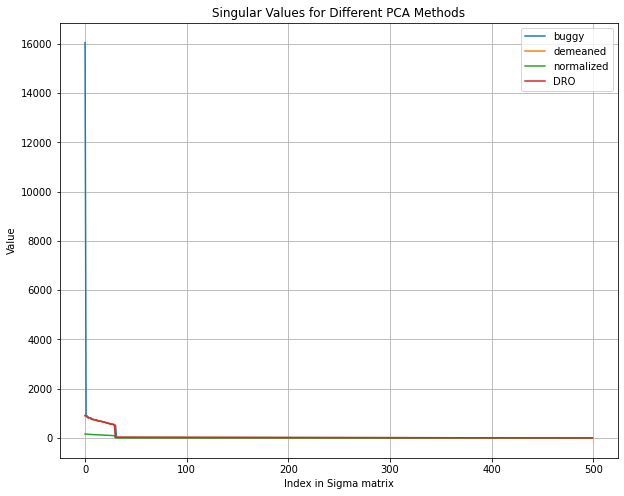

In [126]:
plt.figure(figsize=(10, 8))
for key, values in Sigmas.items():
    plt.plot(values, label=key)
plt.title('Singular Values for Different PCA Methods')
plt.xlabel('Index in Sigma matrix')
plt.ylabel('Value')
plt.legend()
#plt.yscale('log')  
plt.grid(True)
plt.show()

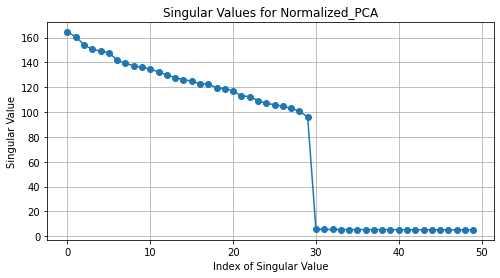

In [127]:
values = Sigmas['normalized']
plt.figure(figsize=(8, 4))
plt.plot(values[:50], marker='o')
plt.title(f'Singular Values for Normalized_PCA')
plt.xlabel('Index of Singular Value')
plt.ylabel('Singular Value')
#plt.yscale('log')
plt.grid(True)
plt.show()

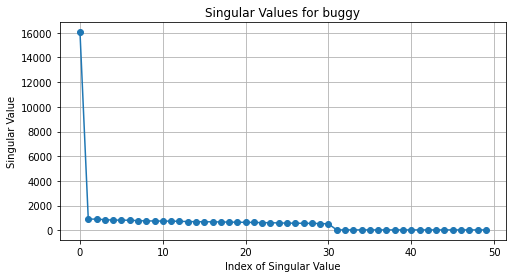

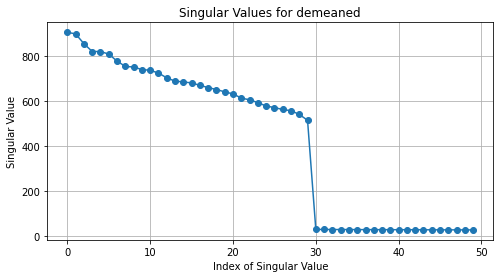

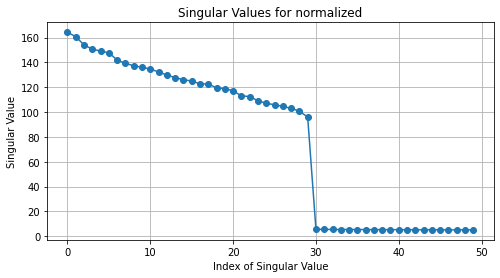

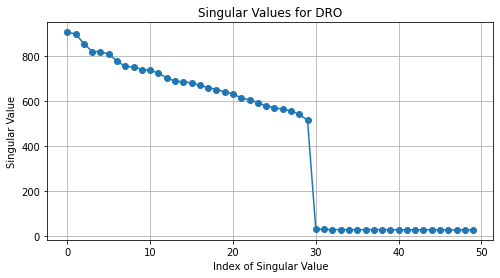

In [128]:
for key, values in Sigmas.items():
    plt.figure(figsize=(8, 4))
    plt.plot(values[:50], marker='o')
    if str(key) == 'Untouched':
        plt.title(f'Singular Values for original data (X = U S VT)')
    else:
        plt.title(f'Singular Values for {key}')
    plt.xlabel('Index of Singular Value')
    plt.ylabel('Singular Value')
    #plt.yscale('log') 
    plt.grid(True)
    plt.show()

In [118]:
### Plotting the reconstructions vs original
Sigmas = {'buggy': [], 'demeaned': [], 'normalized': [], 'DRO' : []}
XR = {'buggy': [], 'demeaned': [], 'normalized': [], 'DRO' : []}
Z, A, Xr, U, S, VT = buggy_PCA(Data2D, 1)
Sigmas['buggy'] = S
XR['buggy'] = Xr.T
Z, A, Xr, U, S, VT = demeaned_PCA(Data2D, 1)
Sigmas['demeaned'] = S
XR['demeaned'] = Xr.T
Z, A, Xr, U, S, VT = normalized_PCA(Data2D, 1)
Sigmas['normalized'] = S
XR['normalized'] = Xr.T
Z, A, Xr, U, S, VT, Xbar = DRO(Data2D, 1)
Sigmas['DRO'] = S
XR['DRO'] = Xr

Shape of X is (2, 50)
Shape of Xr for buggy is (50, 2)


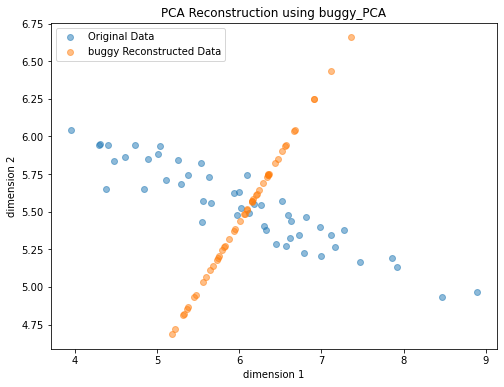

Shape of X is (2, 50)
Shape of Xr for demeaned is (50, 2)


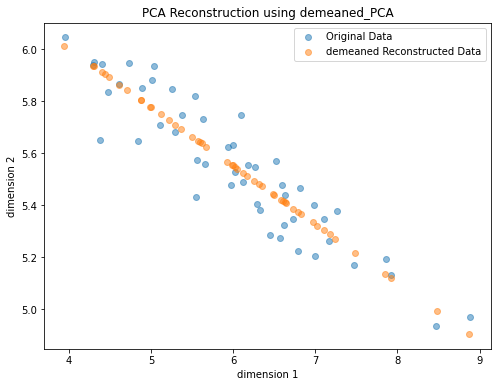

Shape of X is (2, 50)
Shape of Xr for normalized is (50, 2)


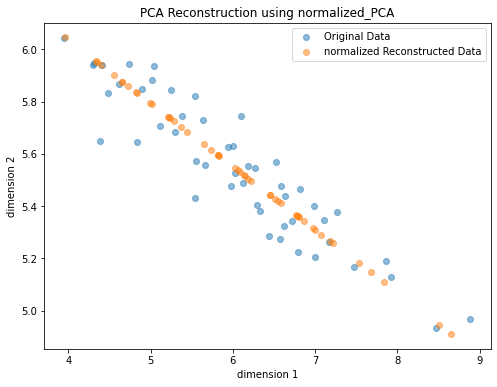

Shape of X is (2, 50)
Shape of Xr for DRO is (50, 2)


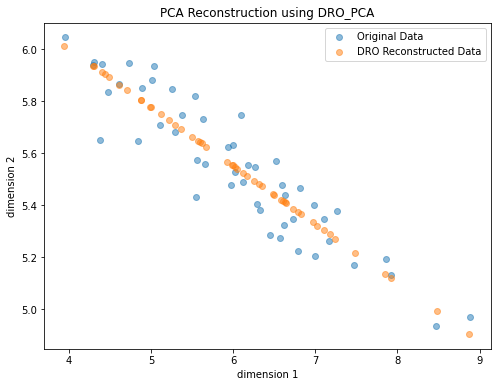

In [119]:
for key in Sigmas.keys():
    plt.figure(figsize=(8, 6))
    Data2D = Data2D
    print(f"Shape of X is {Data2D.shape}")
    Data2D_np = Data2D.to_numpy()
    Data2D_np = Data2D_np.T
    plt.scatter(Data2D_np[:, 0], Data2D_np[:, 1], alpha=0.5, label='Original Data')
    Xr_np = np.array(XR[key])  
    Xr_np = Xr_np
    print(f"Shape of Xr for {key} is {Xr_np.shape}")
    plt.scatter(Xr_np[:, 0], Xr_np[:, 1], alpha=0.5, label=f'{key} Reconstructed Data')
    plt.title(f'PCA Reconstruction using {key}_PCA')
    plt.xlabel('dimension 1')
    plt.ylabel('dimension 2')
    plt.legend()
    plt.show()

In [120]:
### D1000 Error Calc
errors_d1000 = {'buggy': [], 'demeaned': [], 'normalized': [], 'dro' : []}
Xr_d1000 = {'buggy': [], 'demeaned': [], 'normalized': [], 'dro' : []}
Z, A, Xr_buggy, U, S, VT = buggy_PCA(Data1000D, 30)
Xr_d1000['buggy'] = Xr_buggy
errors_d1000['buggy'] = [1, reconstruction_error(Data1000D, Xr_buggy)]
Z, A, Xr_dem, U, S, VT = demeaned_PCA(Data1000D, 30)
Xr_d1000['demeaned'] = Xr_dem
errors_d1000['demeaned'] = [1, reconstruction_error(Data1000D, Xr_dem)]
Z, A, Xr_norm, U, S, VT = normalized_PCA(Data1000D, 30)
Xr_d1000['normalized'] = Xr_norm
errors_d1000['normalized'] = [1, reconstruction_error(Data1000D, Xr_norm)]
Z, A, Xr_dro, U, S, VT, Xbar = DRO(Data1000D, 30)
Xr_d1000['dro'] = Xr_dro
errors_d1000['dro'] = [1, reconstruction_error(Data1000D, Xr_dro.T)]

In [121]:
for key in errors_d1000.keys():
    print(f"Errors for {key} are {errors_d1000[key]}")

Errors for buggy are [1, (401365.6993101792, 802.7313986203584)]
Errors for demeaned are [1, (136522.97948930142, 273.0459589786028)]
Errors for normalized are [1, (136814.29049881164, 273.62858099762326)]
Errors for dro are [1, (136522.97948930142, 273.0459589786028)]
